In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import preprocess as pre

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
ais_train = pd.read_csv("../ais_train.csv", sep="|")
ais_test = pd.read_csv("../ais_test.csv", sep=",")

vessels = pd.read_csv("../vessels.csv", sep="|")
ports = pd.read_csv("../ports.csv", sep="|")
schedules = pd.read_csv("../schedules_to_may_2024.csv", sep="|")

FileNotFoundError: [Errno 2] No such file or directory: '../ais_test.csv'

In [5]:
#Correlation
corr  = boat.corr()
sns.heatmap(corr, annot=True, fmt=".2f")

NameError: name 'boat' is not defined

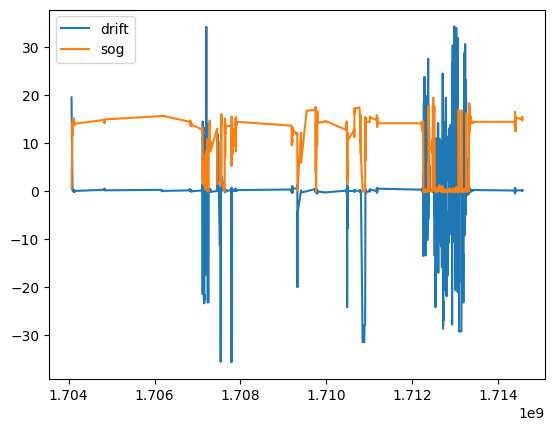

In [6]:
#Drift
plt.plot(boat["time"].to_numpy(), boat["drift"].to_numpy()/10, label="drift")
plt.plot(boat["time"].to_numpy(), boat["sog"].to_numpy(), label="sog")
plt.legend()
plt.show()

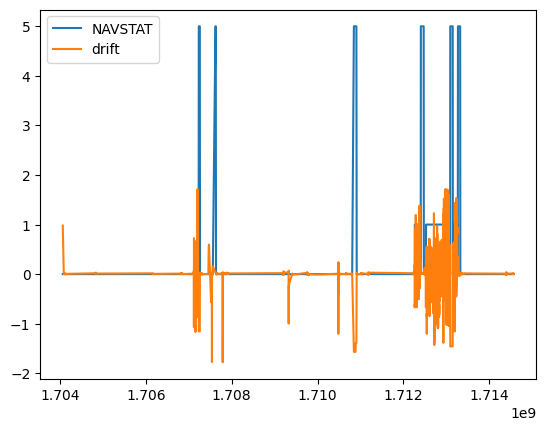

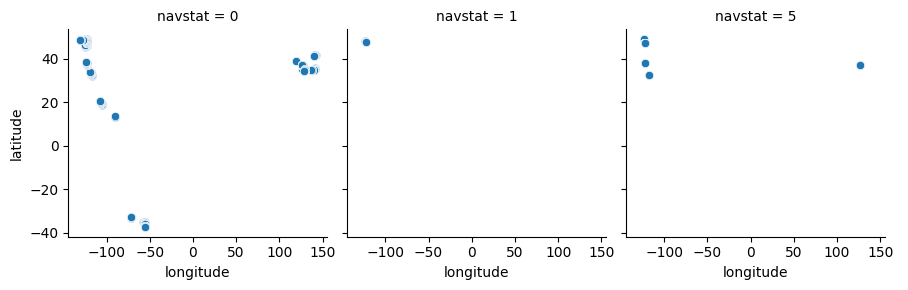

In [7]:
#NAVSTAT
plt.plot(boat["time"].to_numpy(), boat["navstat"].to_numpy(), label="NAVSTAT")
plt.plot(boat["time"].to_numpy(), (boat["drift"].to_numpy()/200), label="drift")
plt.legend()
plt.show()

grid = sns.FacetGrid(boat, col="navstat")
grid.map(sns.scatterplot, "longitude", "latitude")
grid.add_legend()
plt.show()

In [11]:
# --- SETUP BABYYYYY ---
boat = ais_train.copy()[ais_train["vesselId"] == "61e9f3a8b937134a3c4bfdf7"]
boat = pre.singleBoatCleanup(boat)

X = boat.drop(columns=["latitude", "longitude"])

X_train, X_test, y_train, y_test = train_test_split(X, boat[["latitude", "longitude"]], test_size=0.2, random_state=6)

def evaluate(model, y_pred):

    n = len(y_test)
    p = X_test.shape[1]

    mse_latitude = mean_squared_error(y_test['latitude'], y_pred[:, 0])
    mse_longitude = mean_squared_error(y_test['longitude'], y_pred[:, 1])
    r2_latitude = r2_score(y_test['latitude'], y_pred[:, 0])
    r2_latitude_adj = 1 - (1 - r2_latitude) * ((n - 1) / (n - p - 1))
    r2_longitude = r2_score(y_test['longitude'], y_pred[:, 1])
    r2_longitude_adj = 1 - (1 - r2_longitude) * ((n - 1) / (n - p - 1))


    print(f"---- {model} Metrics ----")
    print(f"Mean Squared Error (Latitude): {mse_latitude:.4f}")
    print(f"R-squared (Latitude): {r2_latitude:.4f}, Adjusted R-squared (Latitude): {r2_latitude_adj: .4f}")
    print(f"Mean Squared Error (Longitude): {mse_longitude:.4f}")
    print(f"R-squared (Longitude): {r2_longitude:.4f}, Adjusted R-squared (Latitude): {r2_longitude_adj: .4f}")


In [2]:
# --- LINEAR REGRESSION BABYYYYY ---
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_linreg = linreg.predict(X_test)

#Evaluation
evaluate("Linear Regression", y_pred_linreg)

NameError: name 'LinearRegression' is not defined

In [13]:
# --- XGBOOST BABBYYYYYYY ---
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

evaluate("XGB", y_pred_xgb)


---- XGB Metrics ----
Mean Squared Error (Latitude): 0.1752
R-squared (Latitude): 0.9992, Adjusted R-squared (Latitude):  0.9992
Mean Squared Error (Longitude): 4.0659
R-squared (Longitude): 0.9996, Adjusted R-squared (Latitude):  0.9995


In [7]:
bruh = "2024-00-19 23:59"
shrub = pd.to_datetime(bruh, errors='coerce')
print(shrub)

NaT


In [15]:
def singleBoatCleanup(boat: pd.DataFrame, removeID: bool):
    """ 
    Input a Pandas dataframe of a single boat and output a cleaned version of the dataframe.
    """    

    boat.reset_index(drop=True, inplace=True)
    boat["time"] = boat["time"].astype("datetime64[ns]")

    if removeID:
        boat = boat.drop(columns=["vesselId", "portId"])

    boat["drift"] = boat["cog"] - boat["heading"]

    # --- Find last time we left a port ---
    #Figure out when navstat changes (2pac)
    boat["at_port"] = boat["navstat"].apply(lambda stat: True if stat == 5 else False)
    boat["change"] = boat["at_port"] != boat["at_port"].shift(-1)

    #Pick out rows with navstat == 5 and change == True
    wallah = boat[boat["navstat"] == 5]
    wallah = wallah[wallah["change"] == True]
    indices = wallah.index

    #Caveman fix
    boat["timestamp_last_port"] = np.nan

    for i in indices:
        boat.at[i, "timestamp_last_port"] = boat.at[i, "time"]
    boat["timestamp_last_port"] = boat["timestamp_last_port"].ffill()

    origin = boat.at[0, "time"]
    boat["timestamp_last_port"] = boat["timestamp_last_port"].fillna(origin)

    #Insh'allah
    boat["time_at_sea"] = boat["time"]-boat["timestamp_last_port"]
    boat["time_at_sea"] = boat["time_at_sea"].apply(lambda x: x if x >= pd.Timedelta(0) else pd.Timedelta(0))
    boat = boat.drop(columns=["change", "timestamp_last_port"])

    #etaRaw fixing
    boat["etaRaw"] = boat["etaRaw"].apply(lambda eta: "2024-" + eta)
    boat["etaRaw"] = pd.to_datetime(boat["etaRaw"], errors='coerce') #Set errors to NaT
    boat = boat.dropna(subset=["etaRaw"])

    boat["etaRaw"] = boat["etaRaw"].apply(lambda eta: pd.to_datetime(eta))

    #Fixing pd.timestamp and pd.timedelta to numerical
    boat["time"] = boat["time"].astype("int64") // (10**9)
    boat["etaRaw"] = boat["etaRaw"].astype("int64") // (10**9)
    boat["time_at_sea"] = boat["time_at_sea"].dt.total_seconds()

    return boat

boat = ais_train.copy()[ais_train["vesselId"] == "61e9f45bb937134a3c4c0221"]

boat = singleBoatCleanup(boat, True)
boat.head()


C:\Users\marti\AppData\Local\Temp\ipykernel_1052\3730613127.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-01-06 06:13:32' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  boat.at[i, "timestamp_last_port"] = boat.at[i, "time"]
C:\Users\marti\AppData\Local\Temp\ipykernel_1052\3730613127.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  boat["timestamp_last_port"] = boat["timestamp_last_port"].ffill()


TypeError: can only concatenate str (not "Timestamp") to str